# Entrenando modelos

In [1]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("dataset_rio_5km_week_encoded.csv")

print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print("\nPrimeras filas:")
print(df.head())

print("\nInformación del dataset:")
df.info()

Dataset cargado: 5531 filas, 27 columnas

Primeras filas:
   Code Departamento  distanciaRio  hayRioCercano  temperature_2m  \
0              54028          8.07          False       18.305905   
1               6427          4.98           True       25.878348   
2              50007         42.83          False       23.260704   
3              14063         15.81          False       23.013005   
4              14063         15.81          False       23.013005   

   total_evaporation_sum  volumetric_soil_water_layer_1  seInunda  \
0               1.148527                       0.467691         1   
1               3.236035                       0.206117         1   
2               0.983669                       0.165721         1   
3               3.030844                       0.458341         1   
4               3.030844                       0.458341         1   

   precipitation_week  tipoDeSuelo_Alfisoles  tipoDeSuelo_Aridisoles  ...  \
0               172.5              

In [2]:
# Preparar entradas (X) y salida (y) para el modelo
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Columnas disponibles:\n", df.columns.tolist())
print("\nShape del dataframe:", df.shape)

# --- Definir target y features ---
target = 'seInunda'

# Columnas a usar como features (especificadas por el usuario)
features = ['hayRioCercano', 'temperature_2m', 'total_evaporation_sum', 
            'volumetric_soil_water_layer_1', 'precipitation_week', 
            'tipoDeSuelo_Alfisoles', 'tipoDeSuelo_Aridisoles',
            'tipoDeSuelo_Complejo indiferenci', 'tipoDeSuelo_Entisoles',
            'tipoDeSuelo_Esteros', 'tipoDeSuelo_Inceptisoles',
            'tipoDeSuelo_Lagunas', 'tipoDeSuelo_Medano', 'tipoDeSuelo_Miscelaneas',
            'tipoDeSuelo_Molisoles', 'tipoDeSuelo_Rio', 'tipoDeSuelo_Roca',
            'tipoDeSuelo_Salinas', 'tipoDeSuelo_Ultisoles',
            'tipoDeSuelo_Vertisoles', 'estacion_invierno', 'estacion_otoño',
            'estacion_primavera', 'estacion_verano']

print(f"\nTarget: {target}")
print(f"Features: {len(features)} columnas")

# Verificar que todas las columnas existen
columnas_faltantes = [col for col in features if col not in df.columns]
if columnas_faltantes:
    print(f"\n⚠️ ADVERTENCIA: Columnas faltantes: {columnas_faltantes}")
else:
    print("\n✓ Todas las columnas requeridas están presentes")

# --- Preparar X (features) y y (target) ---
X = df[features].to_numpy(dtype=float)
y = df[target].to_numpy()

# Convertir booleanos a 1/0 si es necesario
y = y.astype(int)

print(f"\nShapes: X={X.shape}, y={y.shape}")
print(f"Distribución del target: {np.bincount(y)} (0=No Inunda, 1=Inunda)")
print(f"  - No Inunda: {np.sum(y==0)} ({100*np.sum(y==0)/len(y):.1f}%)")
print(f"  - Inunda: {np.sum(y==1)} ({100*np.sum(y==1)/len(y):.1f}%)")

# --- Split train/test con estratificación ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nShapes después del split:")
print(f"  X_train={X_train.shape}, y_train={y_train.shape}")
print(f"  X_test={X_test.shape}, y_test={y_test.shape}")

# --- Escalado (StandardScaler) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Datos escalados y listos para el modelo!")
print(f"\n📌 Variables disponibles para el modelo:")
print(f"   - X_train_scaled, X_test_scaled: datos de entrada escalados")
print(f"   - y_train, y_test: etiquetas binarias (0/1)")
print(f"   - scaler: para transformar datos nuevos")
print(f"   - features: lista de nombres de columnas usadas")

Columnas disponibles:
 ['Code Departamento', 'distanciaRio', 'hayRioCercano', 'temperature_2m', 'total_evaporation_sum', 'volumetric_soil_water_layer_1', 'seInunda', 'precipitation_week', 'tipoDeSuelo_Alfisoles', 'tipoDeSuelo_Aridisoles', 'tipoDeSuelo_Complejo indiferenci', 'tipoDeSuelo_Entisoles', 'tipoDeSuelo_Esteros', 'tipoDeSuelo_Inceptisoles', 'tipoDeSuelo_Lagunas', 'tipoDeSuelo_Medano', 'tipoDeSuelo_Miscelaneas', 'tipoDeSuelo_Molisoles', 'tipoDeSuelo_Rio', 'tipoDeSuelo_Roca', 'tipoDeSuelo_Salinas', 'tipoDeSuelo_Ultisoles', 'tipoDeSuelo_Vertisoles', 'estacion_invierno', 'estacion_otoño', 'estacion_primavera', 'estacion_verano']

Shape del dataframe: (5531, 27)

Target: seInunda
Features: 24 columnas

✓ Todas las columnas requeridas están presentes

Shapes: X=(5531, 24), y=(5531,)
Distribución del target: [2805 2726] (0=No Inunda, 1=Inunda)
  - No Inunda: 2805 (50.7%)
  - Inunda: 2726 (49.3%)

Shapes después del split:
  X_train=(4424, 24), y_train=(4424,)
  X_test=(1107, 24), y_te

In [3]:
# Búsqueda de hiperparámetros con Keras Tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# Definir la función que construye el modelo con hiperparámetros variables
def build_model(hp):
    """
    Construye un modelo con hiperparámetros a optimizar:
    - Número de capas ocultas
    - Número de neuronas por capa
    - Tasa de dropout
    - Learning rate
    - Activación en capas ocultas
    """
    model = keras.Sequential()
    
    # Capa de entrada
    input_dim = X_train_scaled.shape[1]
    
    # Número de capas ocultas a probar
    n_layers = hp.Int('n_layers', min_value=1, max_value=6, step=1)
    
    for i in range(n_layers):
        # Número de neuronas por capa
        units = hp.Int(f'units_{i}', min_value=8, max_value=256, step=8)
        
        # Función de activación
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'elu'])
        
        if i == 0:
            model.add(layers.Dense(units, activation=activation, input_dim=input_dim))
        else:
            model.add(layers.Dense(units, activation=activation))
        
        # Dropout para regularización
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    # Capa de salida (clasificación binaria con sigmoid)
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Learning rate variable
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Optimizador a probar
    optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    
    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    # Compilar el modelo
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

# Configurar el tuner
# OBJETIVO: Maximizar RECALL en validación (crítico detectar todas las inundaciones)
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_recall', direction='max'),
    max_trials=20,
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='inundacion_classifier',
    overwrite=True
)

print("Espacio de búsqueda de hiperparámetros:")
print(tuner.search_space_summary())

# Configurar callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Ejecutar la búsqueda
print("\n🔍 Iniciando búsqueda de hiperparámetros...")
print("Esto puede tomar varios minutos.\n")

tuner.search(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n" + "="*70)
print("🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print("="*70)
print(f"Número de capas: {best_hps.get('n_layers')}")
for i in range(best_hps.get('n_layers')):
    print(f"  Capa {i+1}: {best_hps.get(f'units_{i}')} neuronas, "
          f"activación={best_hps.get(f'activation_{i}')}, "
          f"dropout={best_hps.get(f'dropout_{i}')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print("="*70)

# Construir y entrenar el mejor modelo
print("\n📊 Entrenando el mejor modelo...")
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar en el conjunto de test
print("\n📈 Evaluación en el conjunto de test:")
test_results = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Recall: {test_results[2]:.4f}  ← ¡Métrica principal!")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

# Guardar el mejor modelo
best_model.save('mejor_modelo_inundacion.h5')
print("\n✅ Modelo guardado como 'mejor_modelo_inundacion.h5'")

Trial 20 Complete [00h 01m 23s]
val_recall: 0.7401847541332245

Best val_recall So Far: 0.9595842957496643
Total elapsed time: 00h 20m 33s

🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:
Número de capas: 6
  Capa 1: 224 neuronas, activación=elu, dropout=0.1
  Capa 2: 32 neuronas, activación=relu, dropout=0.4
  Capa 3: 216 neuronas, activación=tanh, dropout=0.2
  Capa 4: 64 neuronas, activación=tanh, dropout=0.30000000000000004
  Capa 5: 136 neuronas, activación=relu, dropout=0.2
  Capa 6: 104 neuronas, activación=elu, dropout=0.30000000000000004
Optimizer: rmsprop
Learning rate: 0.01

📊 Entrenando el mejor modelo...
Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6378 - auc: 0.6816 - loss: 0.7231 - precision: 0.6266 - recall: 0.6588 - val_accuracy: 0.6915 - val_auc: 0.7968 - val_loss: 0.6831 - val_precision: 0.7685 - val_recall: 0.5289
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6813 - auc: 0.7324 - loss: 0.6226 - precision: 0.6707 - recall: 0.6961 - v

Test Loss: 0.5585
Test Accuracy: 0.7127
Test Recall: 0.7930  ← ¡Métrica principal!
Test Precision: 0.6787
Test AUC: 0.7834

✅ Modelo guardado como 'mejor_modelo_inundacion.h5'


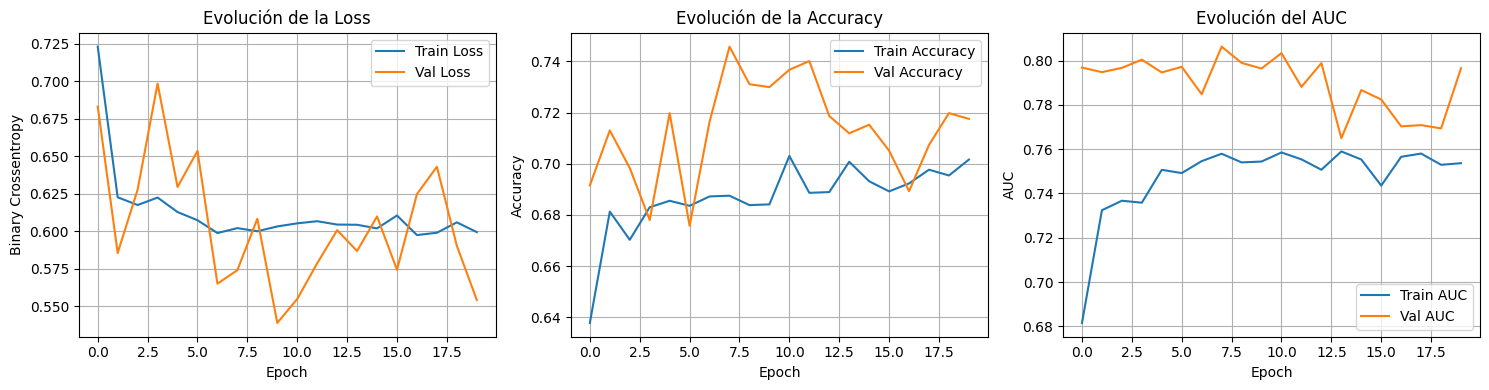

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


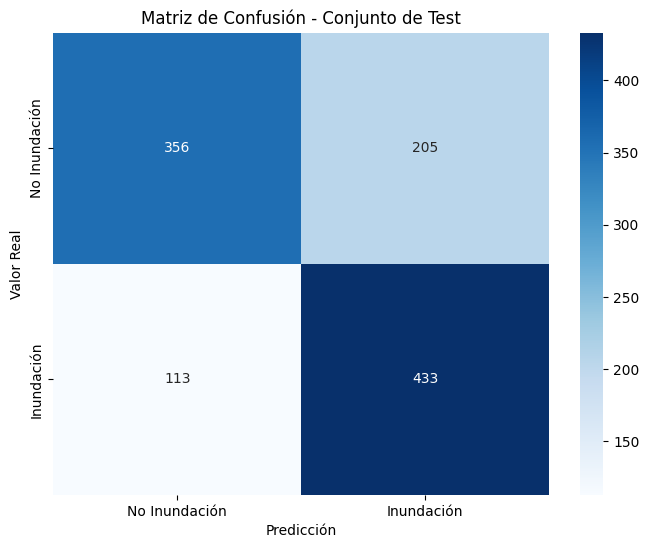


📊 Reporte de Clasificación:
               precision    recall  f1-score   support

No Inundación     0.7591    0.6346    0.6913       561
   Inundación     0.6787    0.7930    0.7314       546

     accuracy                         0.7127      1107
    macro avg     0.7189    0.7138    0.7113      1107
 weighted avg     0.7194    0.7127    0.7111      1107


🏗️ Arquitectura del mejor modelo:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 224)            │         5,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 216)            │         7,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 216)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 136)            │         8,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 104)            │        14,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,020 (445.39 KB)

 Trainable params: 57,009 (222.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 57,011 (222.70 KB)

In [4]:
# Visualización de resultados del entrenamiento
import matplotlib.pyplot as plt

# Graficar la evolución del entrenamiento
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Evolución de la Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Binary Crossentropy')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Evolución de la Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_title('Evolución del AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Matriz de confusión en el conjunto de test
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_proba = best_model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Inundación', 'Inundación'],
            yticklabels=['No Inundación', 'Inundación'])
plt.title('Matriz de Confusión - Conjunto de Test')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

# Reporte de clasificación
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Inundación', 'Inundación'],
                          digits=4))

# Mostrar el resumen del mejor modelo
print("\n🏗️ Arquitectura del mejor modelo:")
best_model.summary()

📊 PREDICCIONES CON PROBABILIDADES
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Ejemplos de predicciones (primeros 20 casos del test):
----------------------------------------------------------------------
Índice   Probabilidad    Predicción      Real      
----------------------------------------------------------------------
0        0.1463 (= 14.6%)   No Inundación ✗ No Inundación ✓
1        0.3365 (= 33.6%)   No Inundación ✗ No Inundación ✓
2        0.3083 (= 30.8%)   No Inundación ✗ Inundación ✗
3        0.3473 (= 34.7%)   No Inundación ✗ No Inundación ✓
4        0.6519 (= 65.2%)   Inundación ✓    Inundación ✓
5        0.5950 (= 59.5%)   Inundación ✓    Inundación ✓
6        0.1037 (= 10.4%)   No Inundación ✗ No Inundación ✓
7        0.5832 (= 58.3%)   Inundación ✓    Inundación ✓
8        0.5386 (= 53.9%)   Inundación ✓    Inundación ✓
9        0.1287 (= 12.9%)   No Inundación ✗ No Inundación ✓
10       0.0973 (=  9.7%)   No Inundación ✗ No Inundación ✓
11       0.3401 (= 34.0%)   No I

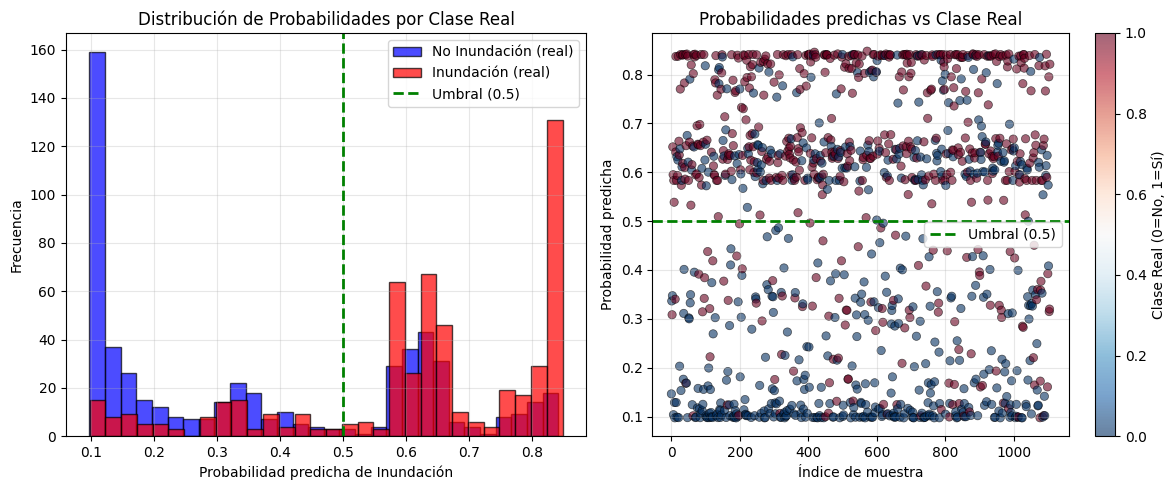


ℹ️  INTERPRETACIÓN:
• El modelo devuelve un valor entre 0.0 y 1.0
• 0.0 = 0% de probabilidad de inundación (casi seguro que NO)
• 0.5 = 50% de probabilidad (umbral de decisión)
• 1.0 = 100% de probabilidad de inundación (casi seguro que SÍ)
• Valores cercanos a 0 o 1 indican alta confianza
• Valores cerca de 0.5 indican incertidumbre

💡 Para usar el modelo con nuevos datos:
   probabilidad = predecir_inundacion(datos_nuevos)
   donde 'datos_nuevos' debe tener las mismas columnas que X_train


In [5]:
# 🎯 Predicciones con probabilidades
# El modelo devuelve un valor entre 0 y 1 que representa la probabilidad de inundación

print("="*70)
print("📊 PREDICCIONES CON PROBABILIDADES")
print("="*70)

# Obtener probabilidades para el conjunto de test
probabilidades = best_model.predict(X_test_scaled).flatten()

# Mostrar ejemplos de predicciones
print("\nEjemplos de predicciones (primeros 20 casos del test):")
print("-" * 70)
print(f"{'Índice':<8} {'Probabilidad':<15} {'Predicción':<15} {'Real':<10}")
print("-" * 70)

for i in range(min(20, len(y_test))):
    prob = probabilidades[i]
    pred_class = "Inundación ✓" if prob > 0.5 else "No Inundación ✗"
    real_class = "Inundación" if y_test[i] == 1 else "No Inundación"
    correcto = "✓" if (prob > 0.5) == (y_test[i] == 1) else "✗"
    
    print(f"{i:<8} {prob:>6.4f} (={prob*100:5.1f}%)   {pred_class:<15} {real_class:<10} {correcto}")

print("-" * 70)

# Distribución de probabilidades
print("\n📈 Distribución de probabilidades predichas:")
print(f"  Mínimo: {probabilidades.min():.4f}")
print(f"  Máximo: {probabilidades.max():.4f}")
print(f"  Media: {probabilidades.mean():.4f}")
print(f"  Mediana: {np.median(probabilidades):.4f}")

# Histograma de probabilidades
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(probabilidades[y_test == 0], bins=30, alpha=0.7, label='No Inundación (real)', color='blue', edgecolor='black')
plt.hist(probabilidades[y_test == 1], bins=30, alpha=0.7, label='Inundación (real)', color='red', edgecolor='black')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Umbral (0.5)')
plt.xlabel('Probabilidad predicha de Inundación')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades por Clase Real')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(range(len(probabilidades)), probabilidades, 
           c=y_test, cmap='RdBu_r', alpha=0.6, edgecolors='black', linewidth=0.5)
plt.axhline(y=0.5, color='green', linestyle='--', linewidth=2, label='Umbral (0.5)')
plt.xlabel('Índice de muestra')
plt.ylabel('Probabilidad predicha')
plt.title('Probabilidades predichas vs Clase Real')
plt.colorbar(label='Clase Real (0=No, 1=Sí)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ℹ️  INTERPRETACIÓN:")
print("="*70)
print("• El modelo devuelve un valor entre 0.0 y 1.0")
print("• 0.0 = 0% de probabilidad de inundación (casi seguro que NO)")
print("• 0.5 = 50% de probabilidad (umbral de decisión)")
print("• 1.0 = 100% de probabilidad de inundación (casi seguro que SÍ)")
print("• Valores cercanos a 0 o 1 indican alta confianza")
print("• Valores cerca de 0.5 indican incertidumbre")
print("="*70)

# Función auxiliar para hacer predicciones individuales
def predecir_inundacion(datos_nuevos, mostrar_detalle=True):
    """
    Predice la probabilidad de inundación para datos nuevos.
    
    Args:
        datos_nuevos: array o DataFrame con las mismas features que el entrenamiento
        mostrar_detalle: si True, muestra interpretación detallada
    
    Returns:
        probabilidad: valor entre 0 y 1
    """
    # Escalar los datos nuevos
    datos_escalados = scaler.transform(datos_nuevos)
    
    # Predecir
    prob = best_model.predict(datos_escalados, verbose=0).flatten()[0]
    
    if mostrar_detalle:
        print(f"\n🔮 Predicción:")
        print(f"   Probabilidad de inundación: {prob:.4f} ({prob*100:.2f}%)")
        print(f"   Probabilidad de NO inundación: {1-prob:.4f} ({(1-prob)*100:.2f}%)")
        
        if prob > 0.8:
            print(f"   ⚠️  ALTA probabilidad de inundación")
        elif prob > 0.5:
            print(f"   ⚡ Probabilidad moderada de inundación")
        elif prob > 0.2:
            print(f"   ✓ Baja probabilidad de inundación")
        else:
            print(f"   ✓✓ MUY baja probabilidad de inundación")
    
    return prob

print("\n💡 Para usar el modelo con nuevos datos:")
print("   probabilidad = predecir_inundacion(datos_nuevos)")
print("   donde 'datos_nuevos' debe tener las mismas columnas que X_train")

In [ ]:
# 📊 Análisis de Umbrales
print("\n" + "="*60)
print("📊 ANÁLISIS DE UMBRALES DE DECISIÓN")
print("="*60)

from sklearn.metrics import precision_recall_curve, auc

# Probar diferentes umbrales
umbrales = [0.3, 0.4, 0.5, 0.6, 0.7]
resultados = []

for umbral in umbrales:
    y_pred_umbral = (y_pred_proba >= umbral).astype(int).flatten()
    
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    
    acc = accuracy_score(y_test, y_pred_umbral)
    recall = recall_score(y_test, y_pred_umbral)
    precision = precision_score(y_test, y_pred_umbral)
    f1 = f1_score(y_test, y_pred_umbral)
    
    resultados.append({
        'Umbral': umbral,
        'Accuracy': acc,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1
    })
    
    print(f"\n🎯 Umbral: {umbral}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

# Crear DataFrame con los resultados
df_umbrales = pd.DataFrame(resultados)

# Visualización de umbrales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Métricas vs Umbral
axes[0].plot(df_umbrales['Umbral'], df_umbrales['Accuracy'], marker='o', label='Accuracy', linewidth=2)
axes[0].plot(df_umbrales['Umbral'], df_umbrales['Recall'], marker='s', label='Recall', linewidth=2)
axes[0].plot(df_umbrales['Umbral'], df_umbrales['Precision'], marker='^', label='Precision', linewidth=2)
axes[0].plot(df_umbrales['Umbral'], df_umbrales['F1-Score'], marker='d', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Umbral de Decisión')
axes[0].set_ylabel('Valor de Métrica')
axes[0].set_title('Métricas vs Umbral de Decisión')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(umbrales)

# Gráfico 2: Curva Precision-Recall
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_proba.flatten())
pr_auc = auc(recall_vals, precision_vals)

axes[1].plot(recall_vals, precision_vals, linewidth=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
axes[1].scatter(df_umbrales['Recall'], df_umbrales['Precision'], 
                c='red', s=100, zorder=5, label='Umbrales probados')

# Anotar los umbrales
for i, umbral in enumerate(umbrales):
    axes[1].annotate(f'{umbral}', 
                     (df_umbrales['Recall'].iloc[i], df_umbrales['Precision'].iloc[i]),
                     textcoords="offset points", xytext=(10, -5), fontsize=9)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
print("\n📋 Tabla de Resultados por Umbral:")
print(df_umbrales.to_string(index=False))

# Recomendaciones
print("\n" + "="*60)
print("💡 RECOMENDACIONES")
print("="*60)
print("\n🔹 Umbral 0.3-0.4: Mayor Recall - Detecta más inundaciones pero con más falsos positivos")
print("   → Usar cuando el costo de perder una inundación real es alto")
print("\n🔹 Umbral 0.5: Balance estándar - Equilibrio entre Precision y Recall")
print("   → Usar como punto de partida para aplicaciones generales")
print("\n🔹 Umbral 0.6-0.7: Mayor Precision - Menos falsos positivos pero puede perder inundaciones")
print("   → Usar cuando se necesita alta confianza en las predicciones positivas")

# Identificar el mejor umbral según F1-Score
best_idx = df_umbrales['F1-Score'].idxmax()
best_threshold = df_umbrales.loc[best_idx, 'Umbral']
best_f1 = df_umbrales.loc[best_idx, 'F1-Score']

print(f"\n🏆 Mejor umbral según F1-Score: {best_threshold} (F1 = {best_f1:.4f})")